## DeepCycle
### This notebook outlines steps required to reproduce approach from DeepCycle manuscript. For data preparation, model training and cell encoding please refer to README.

In [130]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# make user code available:
import sys
from pathlib import Path
module_path = str(Path('../src').absolute())
if module_path not in sys.path:
    sys.path.insert(0, module_path)

# curated_tracks - cell tracks syncronized on 1 division events
# double_division_tracks - cell tracks syncronized on 2 division events
from const import double_division_tracks, curated_tracks, DATA_ROOT

import pickle
import numpy as np
from numpy import savez_compressed, load
import pandas as pd
import cv2
import sompy
from scipy.interpolate import interp1d, NearestNDInterpolator
from scipy.stats import pearsonr

%matplotlib inline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.cm as cm
from matplotlib import pyplot as plt
plt.style.use('_classic_test')

from notebook_functions import umap_transform, plot_distributions,\
                timelapse_single_frame_sync, timelapse_double_frame_sync,\
                circular_tracking, normalize_intensities, project_onto_fluo_plane

log_const = 300

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


locator: <matplotlib.ticker.MaxNLocator object at 0x000000001674F6C8>
Using auto colorbar locator on colorbar
locator: <matplotlib.ticker.MaxNLocator object at 0x000000001674F6C8>
Setting pcolormesh


Accuracy: 0.7276735363477904
[[0.76467981 0.04431642 0.11145579 0.07954797]
 [0.3943662  0.16784038 0.06220657 0.37558685]
 [0.07773217 0.00102617 0.84992304 0.07131862]
 [0.33061224 0.03673469 0.24489796 0.3877551 ]]


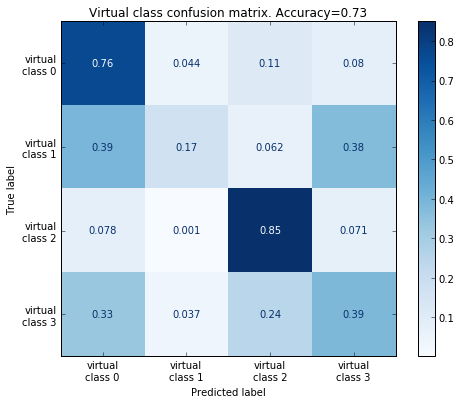

(9753, 4) (9753, 4) (9753, 2)


In [3]:
# load cell descriptors where 
# y - true class [1..4] one hot encoded, 
# descriptors - 4-component vectors obtained on validation set; validation set is double_division_tracks, 
# intensities - 2-component intensities of the cell

with open(DATA_ROOT / 'descriptors.r34.sz48.pkl', 'rb') as f:
    y, descriptors, intensities, df_index = pickle.load(f)
    
y_pred = np.argmax(descriptors, axis=1)
y_true = np.argmax(y, axis=1)
classes = sorted(np.unique(y_true))

acc = (y_pred == y_true).sum() / len(y_pred)
print('Accuracy:', acc)

confusion_mx = confusion_matrix(y_true, y_pred, labels=None, sample_weight=None, normalize='true')
print(confusion_mx)

nl = '\n'
disp = ConfusionMatrixDisplay(confusion_mx, [f'virtual{nl}class {c}' for c in classes])
disp.plot(cmap='Blues')
fig = plt.gcf()
fig.set_size_inches(8, 6)
disp.ax_.set_title(f'Virtual class confusion matrix. Accuracy={acc:.2f}')
# fig.savefig('conf_matrix_2channel.png', dpi=100)
plt.show()

descriptors = np.log(descriptors + 1e-7)
intensities = np.log(intensities + log_const)
print(y.shape, descriptors.shape, intensities.shape)

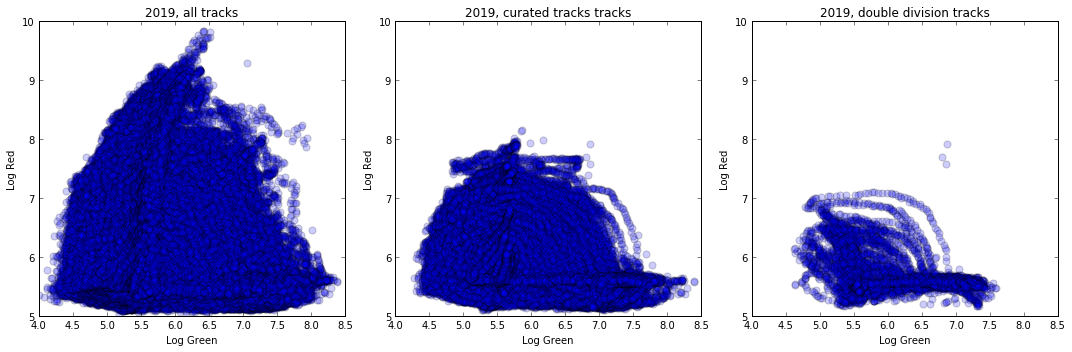

In [4]:
# load cell statistics and plot distributions for all, curated and double division tracks - across all frames.

cell_df = pd.read_csv(DATA_ROOT / 'statistics_mean_std.csv')
intensities_all = cell_df[['GFP_20', 'Cy3_20']].values
intensities_all = np.log(intensities_all + log_const)

intensities_curated_tracks = cell_df.loc[cell_df['TRACK_ID'].isin(curated_tracks), ['GFP_20', 'Cy3_20']].values
intensities_curated_tracks = np.log(intensities_curated_tracks + log_const)

intensities_double_division = cell_df.loc[cell_df['TRACK_ID'].isin(double_division_tracks), ['GFP_20', 'Cy3_20']].values
intensities_double_division = np.log(intensities_double_division + log_const)


plot_distributions((intensities_all, '2019, all tracks'),
                   (intensities_curated_tracks, '2019, curated tracks tracks'),
                   (intensities_double_division, '2019, double division tracks'))

## Timelapse

In [4]:
# 'intensities.csv' contains ~1000 tracks synchronized on 1 division event in 'time' column

df = pd.read_csv(DATA_ROOT / 'intensities.csv', header=[0, 1, 2])

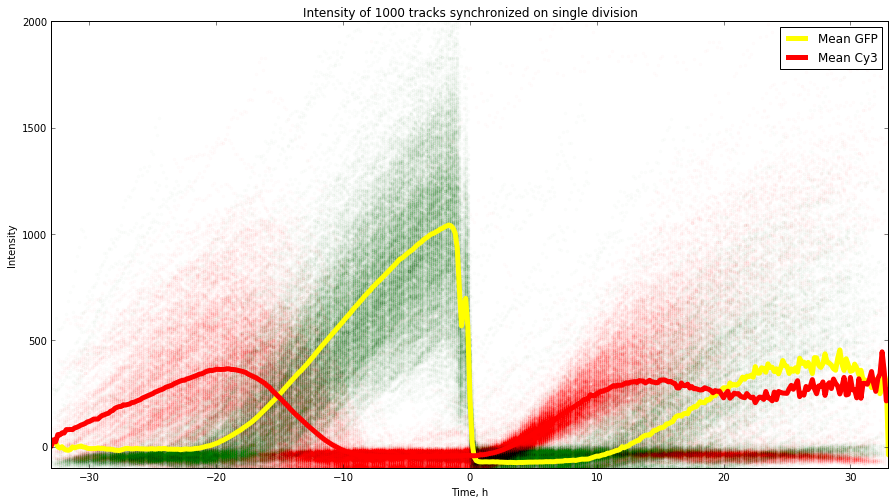

In [5]:
# plot average intensities of single division tracks

average_single_division_track = timelapse_single_frame_sync(df, curated_tracks)

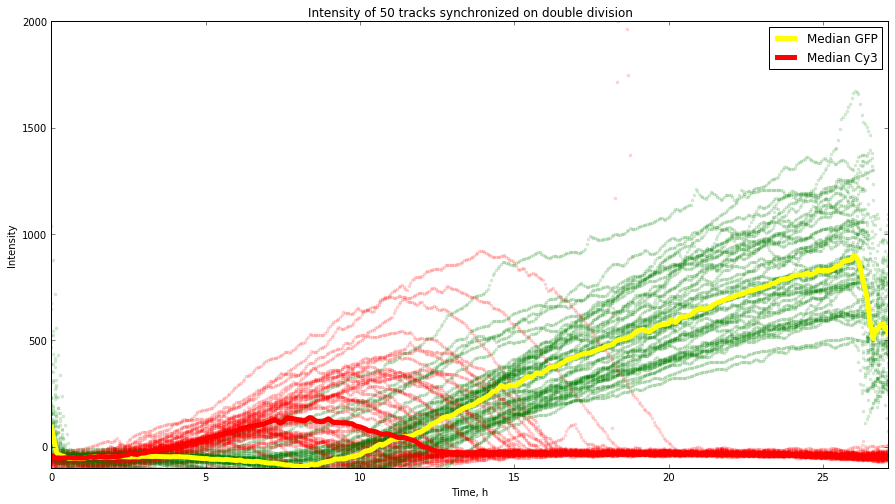

In [6]:
# plot average intensities of double division tracks

average_double_division_track, ax, _ = timelapse_double_frame_sync(df, double_division_tracks, nnods=500)

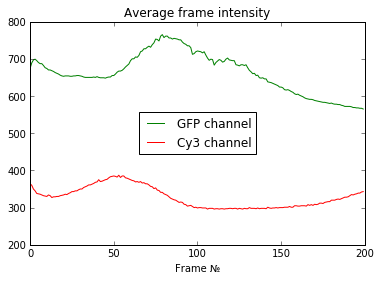

In [7]:
# plot average frame intensities for GFP and Cy3 channels

g_mean_tl, r_mean_tl = df[['gfp_frame_average', 'cy3_frame_average']].T.values

plt.plot(g_mean_tl, 'g', label='GFP channel')
plt.plot(r_mean_tl, 'r', label='Cy3 channel')
plt.legend(loc = 'center')
plt.title('Average frame intensity')
plt.xlabel('Frame №')
plt.show()

## U-Map embedding

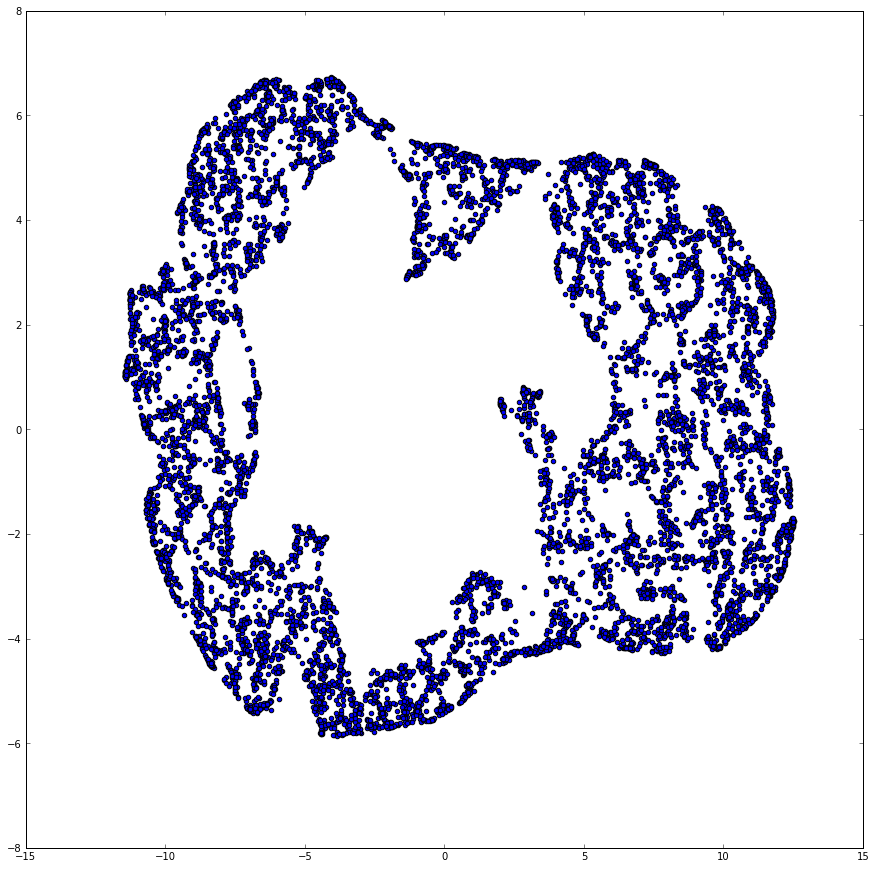

In [8]:
embeddings_preds, fit = umap_transform(descriptors, n_neighbors=300, min_dist=0.05, n_components=2, metric='correlation')

fig = plt.figure(figsize=(15, 15))
plt.scatter(embeddings_preds[:, 0], embeddings_preds[:, 1])

## Finding average track with SOM clustering

In [89]:
mapsize = 30
som = sompy.SOMFactory.build(embeddings_preds, mapsize, mask=None, mapshape='cylinder', lattice='rect',
                             normalization='None', initialization='spherical', neighborhood='gaussian',
                             training='batch', name='sompy', track_history=True)
som.train(n_job=1, verbose=None)

som_matrix = som.codebook.matrix  # SOM track coordinates, shape = mapsize x 2
som_bmu = som._bmu[0].astype(int) # assigned SOM class,  shape = len(embeddings_preds)

input was considered as the numbers of nodes
map size is [1,30]


In [90]:
som_translation_tbl = np.roll(sorted(np.unique(som_bmu))[::-1], -8)  # rearranged class progression 0...29 -> 21...0, 29...22

som_matrix = som_matrix[som_translation_tbl]
som_bmu = som_translation_tbl[som_bmu]

In [91]:
fun = np.median
som_track = []
for cluster in np.sort(np.unique(som_bmu)):
    som_track.append(fun(intensities[som_bmu == cluster], 0))
som_track = np.array(som_track)  # average intensities of SOM clusters, shape = mapsize x 2

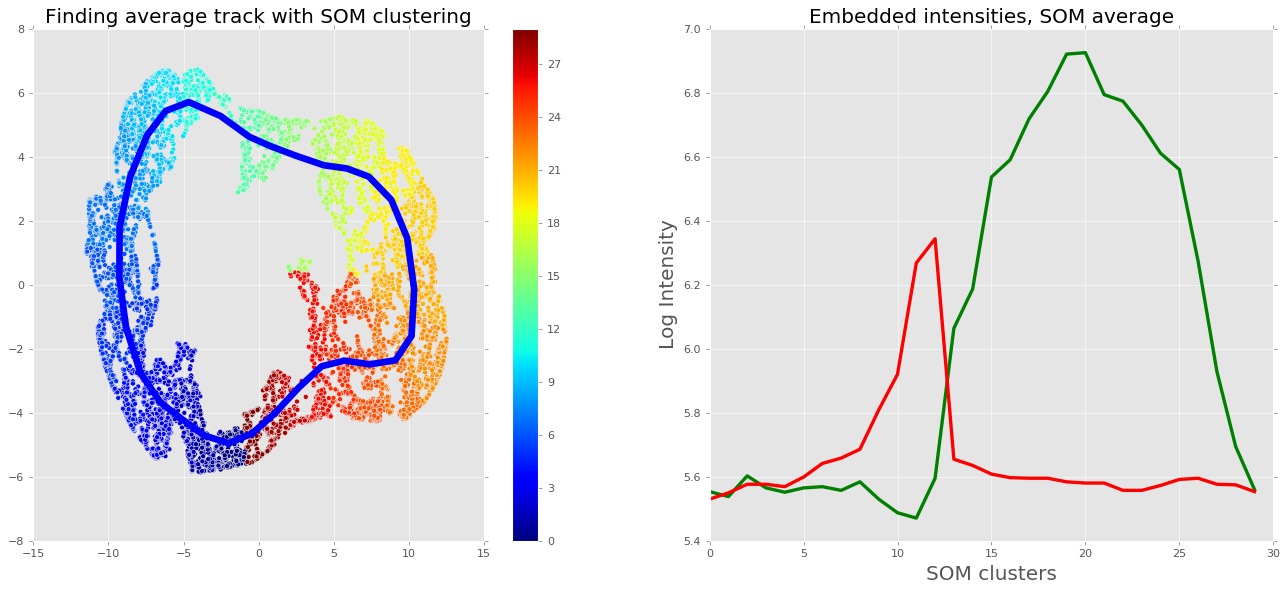

In [92]:
plt.style.use('_classic_test')
plt.style.use('ggplot')
fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(20, 8))

color = 'blue'
im = ax1.scatter(embeddings_preds[:,0], embeddings_preds[:,1], c=som_bmu)
ax1.plot(som_matrix[:,0], som_matrix[:,1], '-', linewidth=6, c=color)
ax1.plot([som_matrix[-1, 0], som_matrix[0, 0]], [som_matrix[-1, 1], som_matrix[0, 1]], '-', linewidth=6, c=color)
ax1.set_title('Finding average track with SOM clustering', fontsize=18)
fig.colorbar(im, ax=ax1)

ax2.plot(som_track[:, 0], c='green', linewidth=3)
ax2.plot(som_track[:, 1], c='red', linewidth=3)
ax2.set_ylabel('Log Intensity', fontsize=18)
ax2.set_xlabel('SOM clusters', fontsize=18)
ax2.set_title('Embedded intensities, SOM average', fontsize=18)


plt.show()

#### Make sure that the SOM path we reconstructed represents time progression. SOM clusters of the Average Double Division track must form gradual progression!

In [105]:
# assign SOM clusters to the Average Double Division track using Nearest-neighbour interpolation
myInterpolator = NearestNDInterpolator(som_matrix, np.arange(len(som_matrix)))
average_double_division_track_som_cluster = myInterpolator(average_double_division_track[:, 0], average_double_division_track[:, 1])

print(average_double_division_track_som_cluster)

[22 22 29  3  3  3  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  4  4  4  4  4  4  4  4  4  5  5  5  5  5  5  5  5  5  5  5  6  6  6  6
  6  6  6  6  6  7  7  7  7  7  7  7  7  7  7  8  8  8  8  8  8  8  8  8
  8  8  8  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9
  9  9  9  9  9  9  9  9  9  9  9  9 10 10 10  9  9  9  9  9  9 10  9  9
  9  9  9  9  9  9  9  9  9  9 10 10  9  9  9  9  9  9 10 10 10 10 10 10
 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 11 11
 11 11 11 11 12 11 12 17 18 18 18 19 19 19 19 19 19 19 19 19 19 20 20 20
 20 20 20 21 21 21 21 21 21 21 22 22 22 22 22 22 22 22 22 22 22 22 22 22
 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 21 21 21 21 22 22 21 21
 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21
 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21
 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21

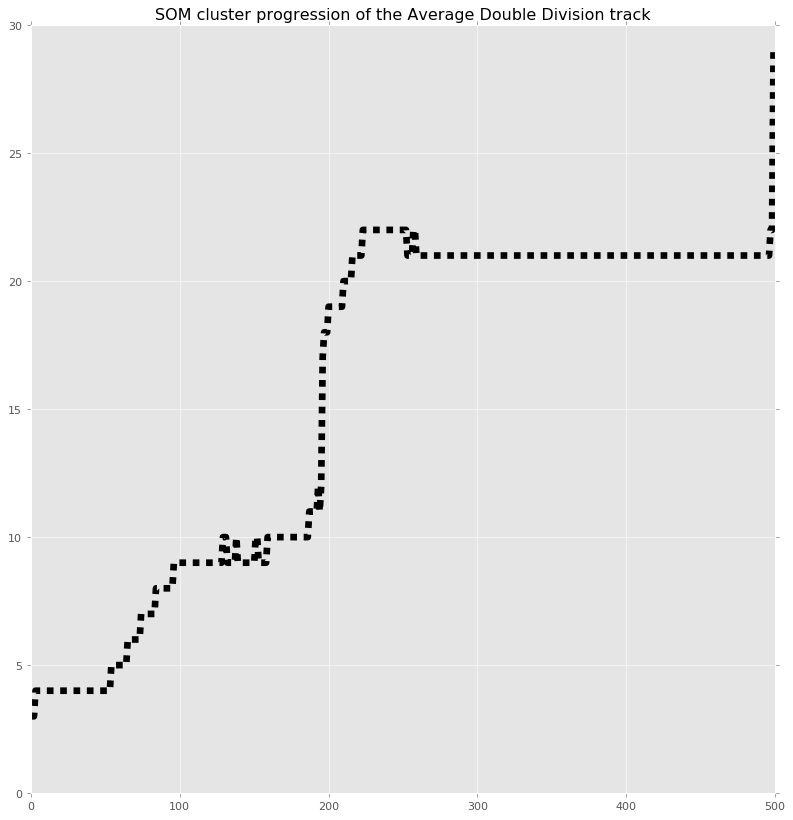

In [116]:
plt.figure(figsize=(12, 12))
# shift by -3 for better visualization
plt.plot(np.roll(average_double_division_track_som_cluster, -3), linewidth=6, c='k', linestyle='--')
plt.title('SOM cluster progression of the Average Double Division track')
plt.show()

### Project SOM averaged trajectory back onto fluo plane

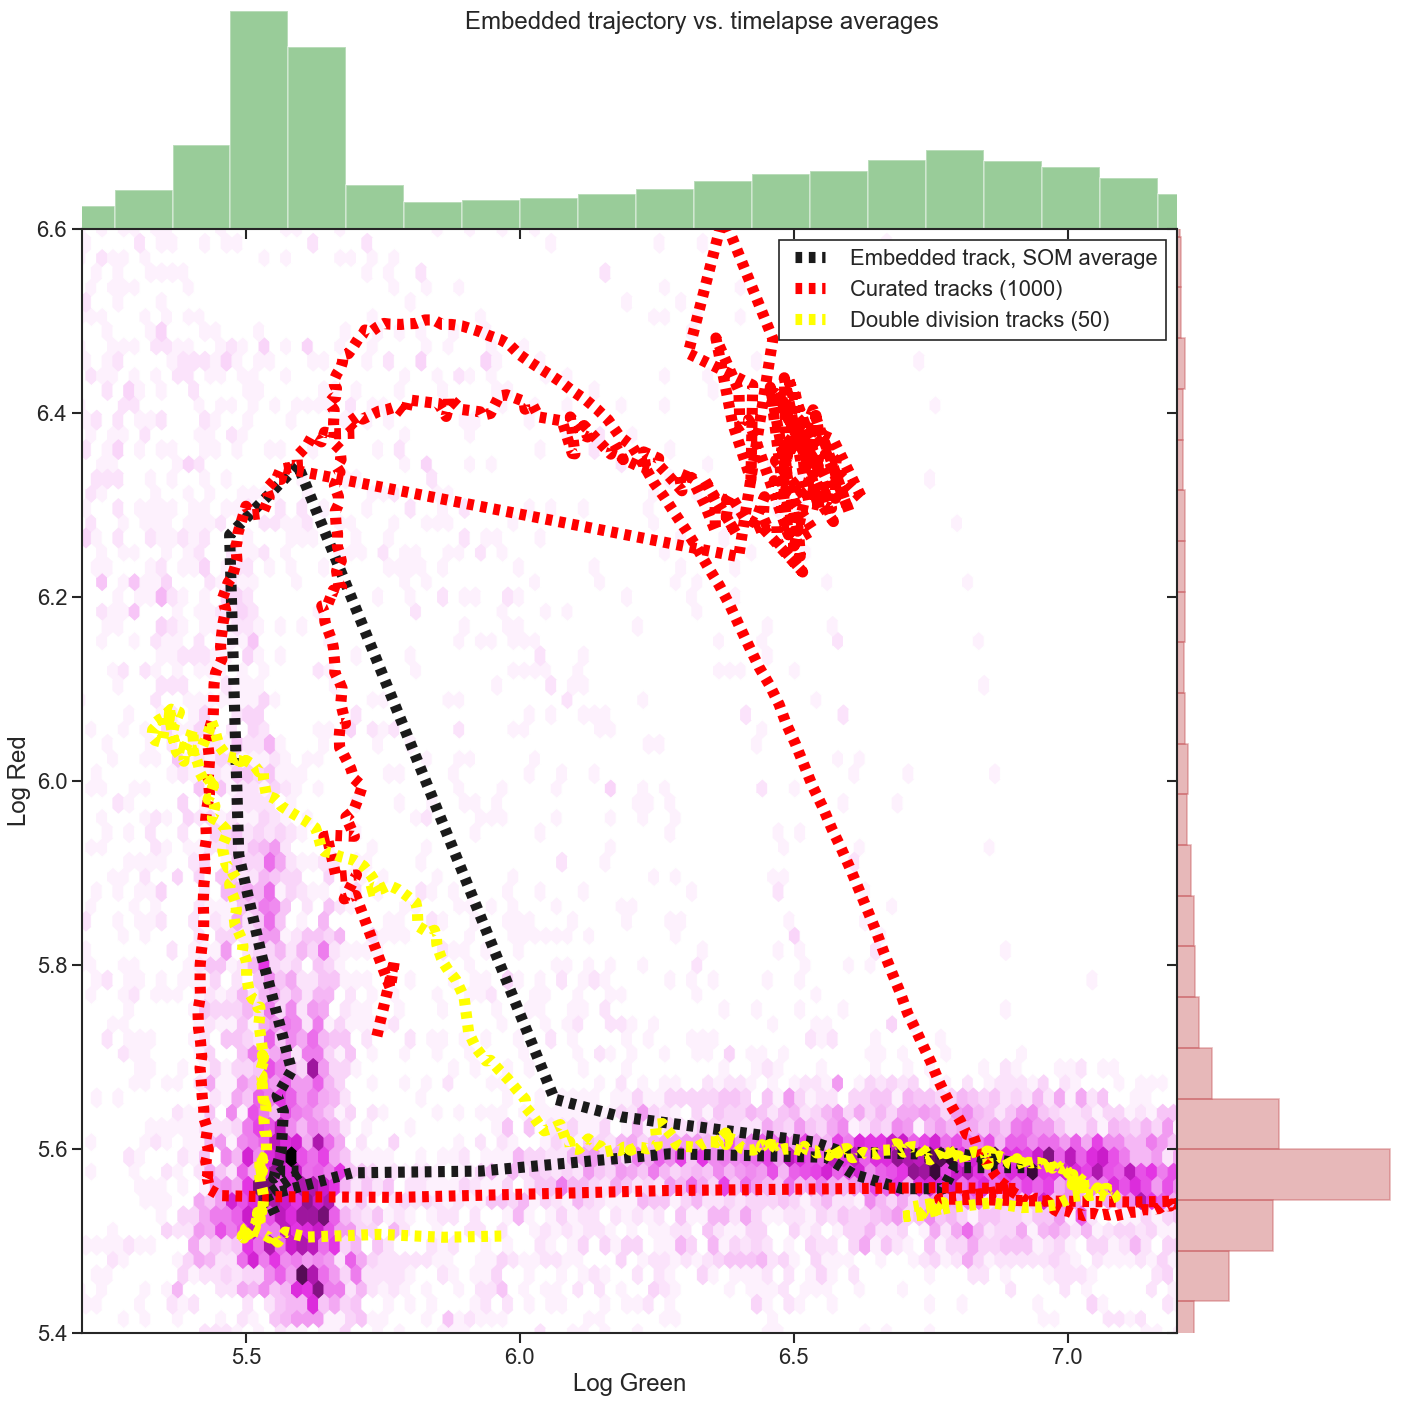

In [117]:
project_onto_fluo_plane(intensities, 
                        (som_track, 'k', 'Embedded track, SOM average'), 
                        (np.log(average_single_division_track + log_const), 'red', 'Curated tracks (1000)'), 
                        (np.log(average_double_division_track + log_const), 'yellow', 'Double division tracks (50)'), 
                        log_const=300)

# Time calibration

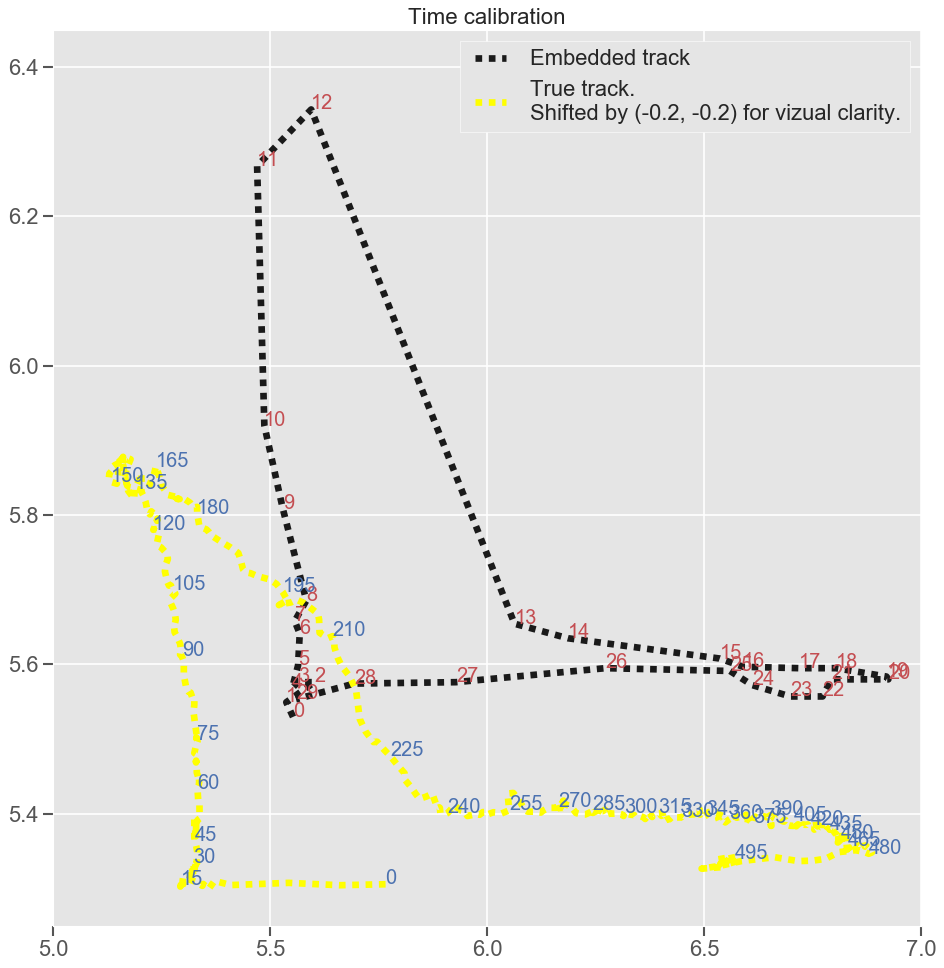

In [118]:
fontsize = 18
linewidth = 6
plt.style.use('ggplot')

plt.figure(figsize=(14, 14))
plt.plot(som_track[:, 0], som_track[:, 1], 'k', linestyle='--', linewidth=linewidth, label='Embedded track')
for i, xy in enumerate(som_track):
    plt.annotate(str(i), xy, fontsize=fontsize, color='r')


shift = (-0.2, -0.2)
true_track = np.log(average_double_division_track + log_const) + shift
plt.plot(true_track[:, 0], true_track[:, 1], 'yellow', linestyle='--', linewidth=linewidth, label=f'True track.\nShifted by ({shift[0]}, {shift[1]}) for vizual clarity.')

for i, xy in enumerate(true_track):
    if (i % 15) != 0:
        continue
    plt.annotate(str(i), xy, fontsize=fontsize, color='b')

plt.ylim((5.25, 6.45))

plt.title('Time calibration', fontsize=20)
plt.legend()
plt.show()

In [119]:
# assign corresponding waypoints
time_calibration = {
    27: 0,
    0: 15,
    11: 150,
    12: 165,
    13: 240,
    20: 480,
    23: 495,
}

real_time_shift = 15
time_calibration = {k: np.mod(v - real_time_shift, len(average_double_division_track)) for k, v in time_calibration.items()}

dd_frames = np.array(list(double_division_tracks.values()))
average_track_duration = np.mean(dd_frames[:, 1] - dd_frames[:, 0]) * 10 / 60  # hours
print(f'Average track duration {average_track_duration:.2f} hours')

Average track duration 27.12 hours


Text(0.5, 1.0, 'Interpolating embedded track time')

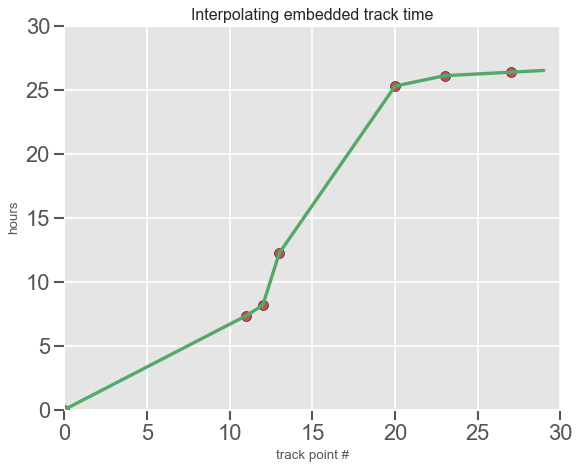

In [120]:
# find time calibration function
embd_track_time = {v: average_track_duration / len(som_track) * k for k, v in time_calibration.items()}
x = np.array(sorted(time_calibration))
y = np.array([time_calibration[i] / (len(true_track) - 1) * average_track_duration for i in x])
f = interp1d(x, y, kind='linear', fill_value='extrapolate')
xnew = np.arange(len(som_track))
ynew = f(xnew)
plt.plot(x, y, 'ro', xnew, ynew, 'g-')
plt.xlabel('track point #')
plt.ylabel('hours')
plt.title('Interpolating embedded track time')

### Plot in real time coordinates

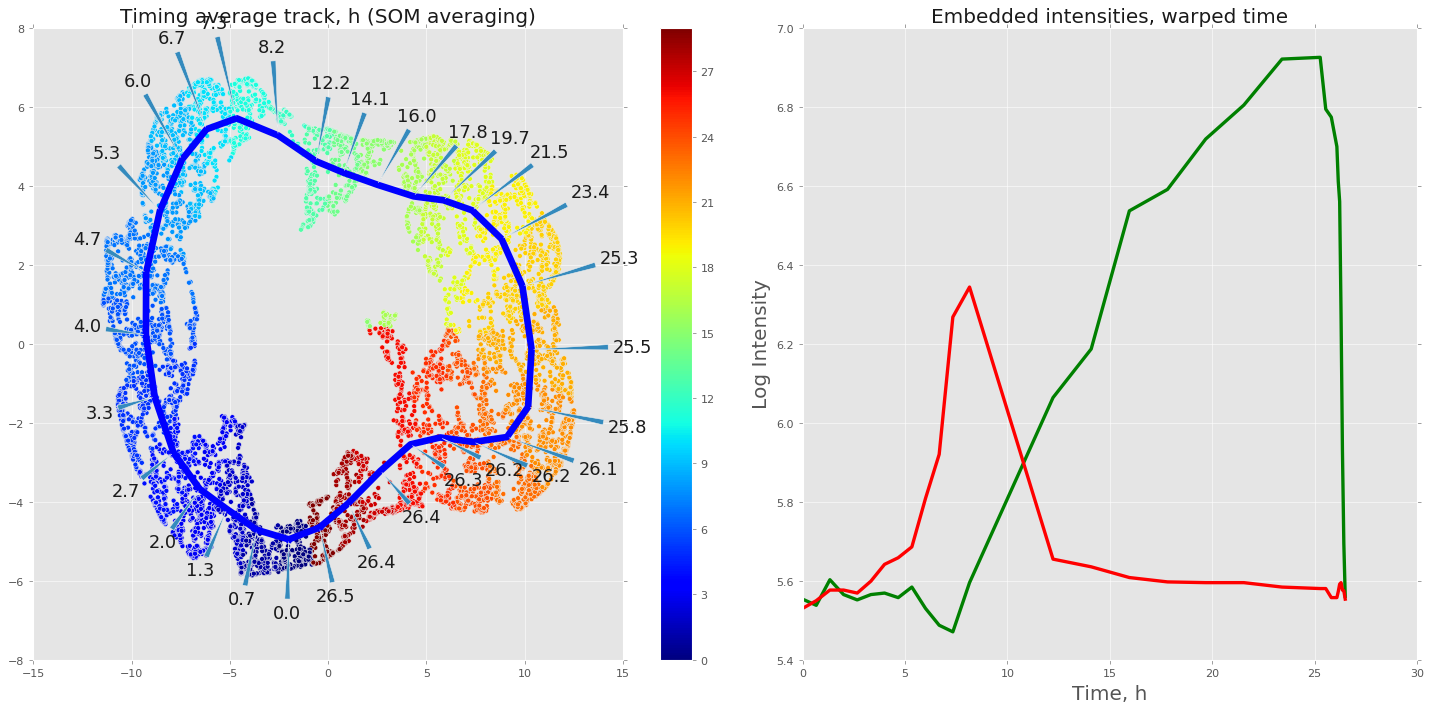

In [121]:
plt.style.use('_classic_test')
plt.style.use('ggplot')
fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(18, 9), gridspec_kw={'width_ratios': [1.2, 1]})

color = 'blue'
im = ax1.scatter(embeddings_preds[:,0], embeddings_preds[:,1], c=som_bmu)
ax1.plot(som_matrix[:,0], som_matrix[:,1], '-', linewidth=6, c=color)
ax1.plot([som_matrix[-1, 0], som_matrix[0, 0]], [som_matrix[-1, 1], som_matrix[0, 1]], '-', linewidth=6, c=color)
ax1.set_title('Timing average track, h (SOM averaging)', fontsize=18)
fig.colorbar(im, ax=ax1)

for h, xy in zip(ynew, som_matrix):
    angle = np.arctan(xy[1] / xy[0]) + (xy[0] < 0) * np.pi
    radius = np.sqrt(np.square(xy).sum())
    radius *= 1.4
    xy_ = np.array([np.cos(angle), np.sin(angle)]) * radius
    ax1.annotate(f'{h:.1f}', xy=xy, xytext=xy_, fontsize=16, color='k', arrowprops={'arrowstyle': 'wedge'})
    
ax2.plot(ynew, som_track[:, 0], c='green', linewidth=3)
ax2.plot(ynew, som_track[:, 1], c='red', linewidth=3)
ax2.set_ylabel('Log Intensity', fontsize=18)
ax2.set_xlabel('Time, h', fontsize=18)
ax2.set_title('Embedded intensities, warped time', fontsize=18)

plt.tight_layout()
plt.show()

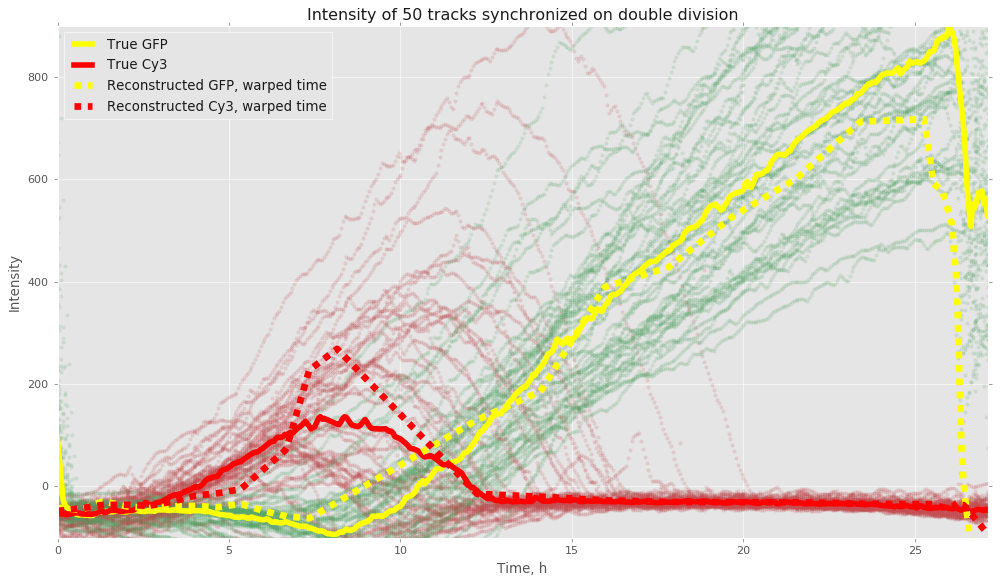

In [122]:
average_double_division_track, ax, _ = timelapse_double_frame_sync(df, double_division_tracks, nnods=500)
x_ = ax.lines[0].get_xdata()

f_green = interp1d(ynew, np.exp(som_track[:, 0]) - log_const, kind='linear', fill_value='extrapolate')
f_red = interp1d(ynew, np.exp(som_track[:, 1]) - log_const, kind='linear', fill_value='extrapolate')
y_green = f_green(x_)
y_red = f_red(x_)

ax.plot(x_, y_green, 'yellow', x_, y_red, 'red', linestyle='--', linewidth=6)
ax.set_ylim((-100, 900))
ax.legend(ax.lines[-4:], ['True GFP', 'True Cy3', 'Reconstructed GFP, warped time', 'Reconstructed Cy3, warped time'], loc=0)
plt.show()

#### Assess correlation between FUCCI intensities of the reconstructed and the Average Double Division track

In [136]:
cy3corr = pearsonr(average_double_division_track[:, 1], y_red)[0]
gfpcorr = pearsonr(average_double_division_track[:, 0], y_green)[0]
print('Pearson correlation coefficients:')
print(f'Cy3={cy3corr:0.2f}\nGFP={gfpcorr:0.2f}')

Pearson correlation coefficients:
Cy3=0.93
GFP=0.89


# Time reconstruction using unseen data

In [56]:
# load all dataset embeddings (obtained with all_cells_prediction.py)

embeddings_preds_all = []
for i in range(20):
    data = load(DATA_ROOT / f'embeddings_preds_all_batch{i}.npz')
    embeddings_preds_all.append(data['arr_0'])
embeddings_preds_all = np.vstack(embeddings_preds_all)

In [57]:
som_bmu_all = som_translation_tbl[som.project_data(embeddings_preds_all)]

In [58]:
fun = np.median
som_track_all = []
for cluster in np.sort(np.unique(som_bmu_all)):
    som_track_all.append(fun(intensities_all[::1][som_bmu_all == cluster], 0))
som_track_all = np.array(som_track_all)

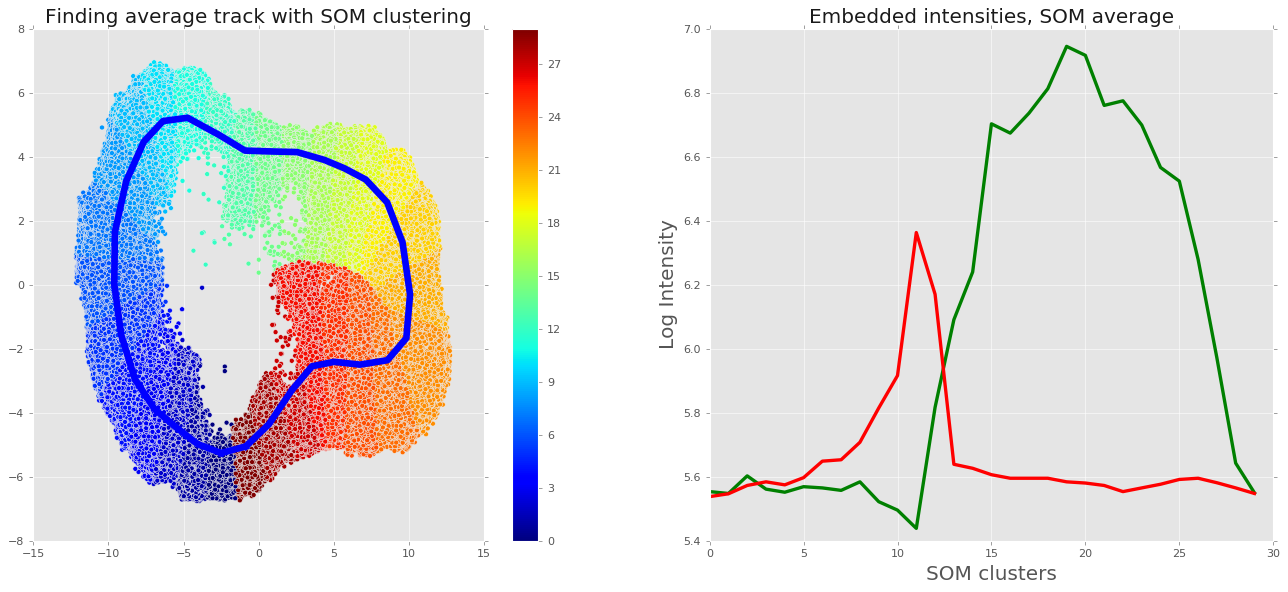

In [59]:
plt.style.use('ggplot')
fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(20, 8))

color = 'blue'
im = ax1.scatter(embeddings_preds_all[:,0], embeddings_preds_all[:,1], c=som_bmu_all)
ax1.plot(som_matrix[:,0], som_matrix[:,1], '-', linewidth=6, c=color)
ax1.plot([som_matrix[-1, 0], som_matrix[0, 0]], [som_matrix[-1, 1], som_matrix[0, 1]], '-', linewidth=6, c=color)
ax1.set_title('Finding average track with SOM clustering', fontsize=18)
fig.colorbar(im, ax=ax1)

ax2.plot(som_track[:, 0], c='green', linewidth=3)
ax2.plot(som_track[:, 1], c='red', linewidth=3)
ax2.set_ylabel('Log Intensity', fontsize=18)
ax2.set_xlabel('SOM clusters', fontsize=18)
ax2.set_title('Embedded intensities, SOM average', fontsize=18)

plt.show()

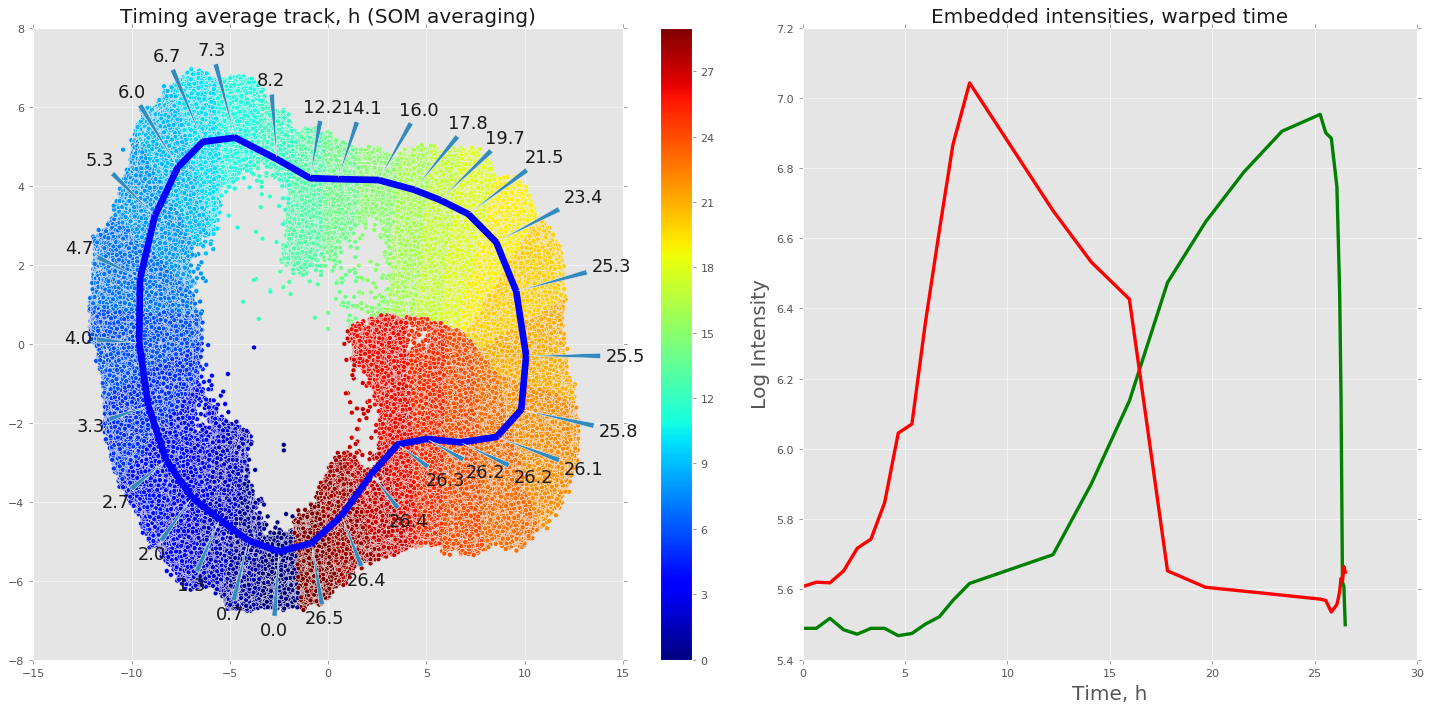

In [71]:
plt.style.use('_classic_test')
plt.style.use('ggplot')
fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(18, 9), gridspec_kw={'width_ratios': [1.2, 1]})

color = 'blue'
im = ax1.scatter(embeddings_preds_all[:,0], embeddings_preds_all[:,1], c=som_bmu_all)
ax1.plot(som_matrix[:,0], som_matrix[:,1], '-', linewidth=6, c=color)
ax1.plot([som_matrix[-1, 0], som_matrix[0, 0]], [som_matrix[-1, 1], som_matrix[0, 1]], '-', linewidth=6, c=color)
ax1.set_title('Timing average track, h (SOM averaging)', fontsize=18)
fig.colorbar(im, ax=ax1)

for h, xy in zip(ynew, som_matrix):
    angle = np.arctan(xy[1] / xy[0]) + (xy[0] < 0) * np.pi
    radius = np.sqrt(np.square(xy).sum())
    radius *= 1.4
    xy_ = np.array([np.cos(angle), np.sin(angle)]) * radius
    ax1.annotate(f'{h:.1f}', xy=xy, xytext=xy_, fontsize=16, color='k', arrowprops={'arrowstyle': 'wedge'})
    
ax2.plot(ynew, som_track_all[:, 0], c='green', linewidth=3)
ax2.plot(ynew, som_track_all[:, 1], c='red', linewidth=3)
ax2.set_ylabel('Log Intensity', fontsize=18)
ax2.set_xlabel('Time, h', fontsize=18)
ax2.set_title('Embedded intensities, warped time', fontsize=18)

# plt.suptitle('Intensity of 2.7 mln cells projected with U-map and SOM, pretrained on 50 double division tracks', 
#              y=1.0, fontsize=18)

plt.tight_layout()
plt.savefig('SOM.png')
plt.show()

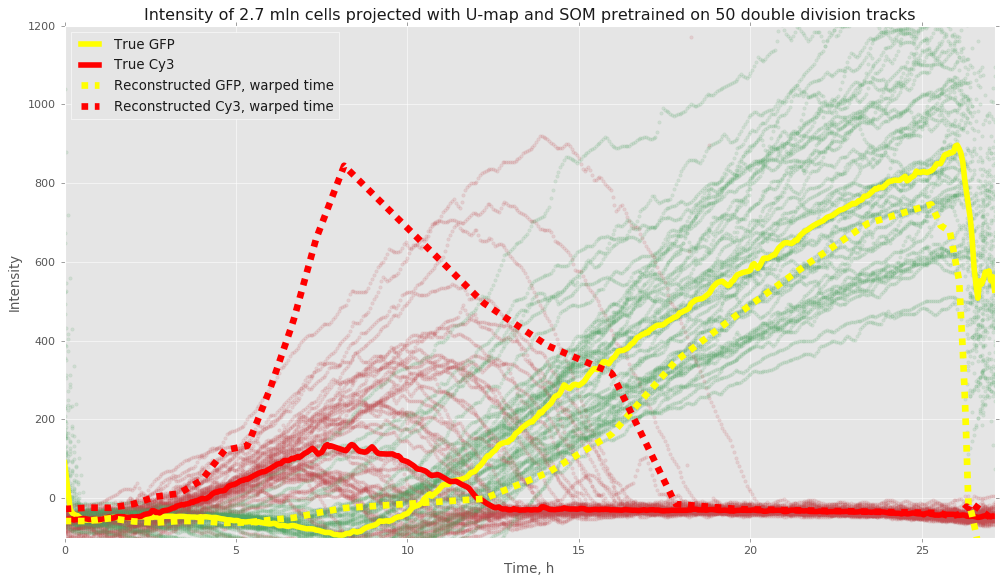

In [64]:
average_double_division_track, ax, _ = timelapse_double_frame_sync(df, double_division_tracks, nnods=500,
                                                                  title='Intensity of 2.7 mln cells projected with U-map and SOM pretrained on 50 double division tracks')
x_ = ax.lines[0].get_xdata()

f_green = interp1d(ynew, np.exp(som_track_all[:, 0]) - log_const, kind='linear', fill_value='extrapolate')
f_red = interp1d(ynew, np.exp(som_track_all[:, 1]) - log_const, kind='linear', fill_value='extrapolate')
y_green = f_green(x_)
y_red = f_red(x_)

ax.plot(x_, y_green, 'yellow', x_, y_red, 'red', linestyle='--', linewidth=6)
ax.set_ylim((-100, 1200))
ax.legend(ax.lines[-4:], ['True GFP', 'True Cy3', 'Reconstructed GFP, warped time', 'Reconstructed Cy3, warped time'], loc=0)
plt.show()

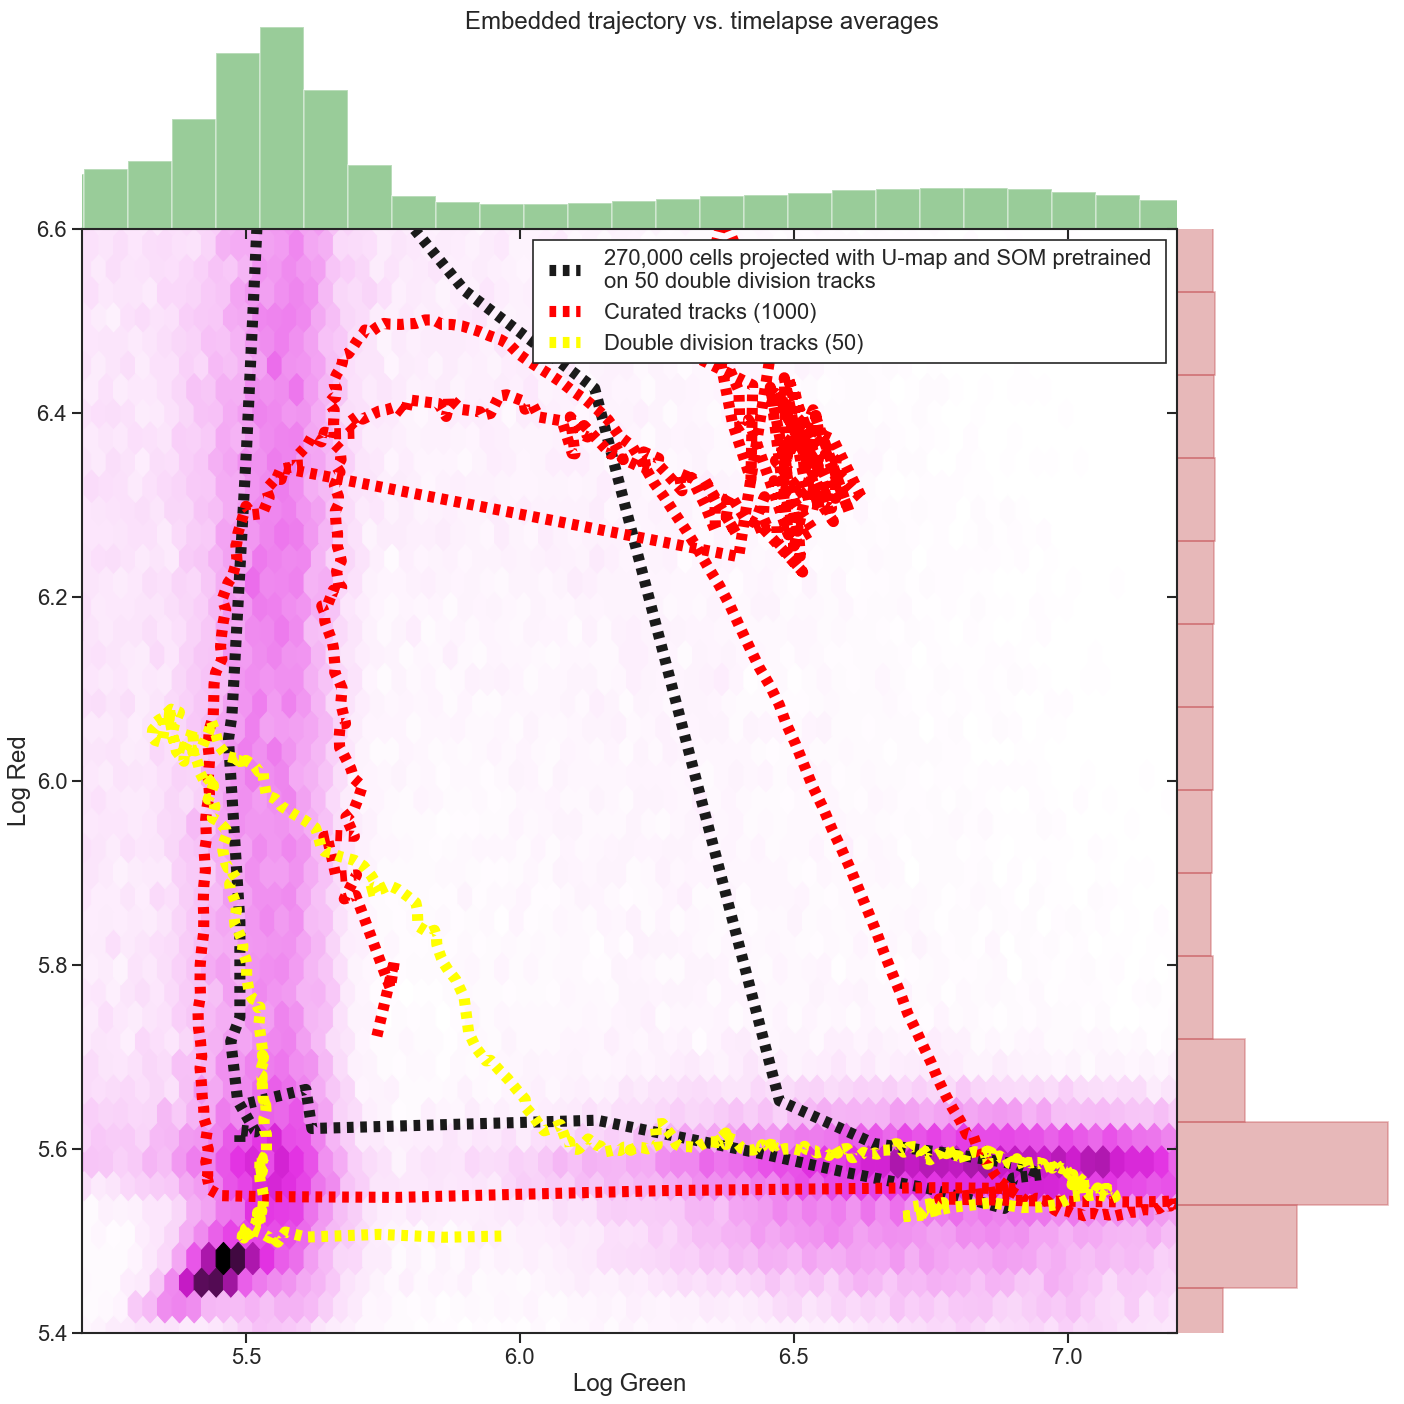

In [69]:
project_onto_fluo_plane(intensities_all[::10], 
                        (som_track_all, 'k', '270,000 cells projected with U-map and SOM pretrained \non 50 double division tracks'), 
                        (np.log(average_single_division_track + log_const), 'red', 'Curated tracks (1000)'), 
                        (np.log(average_double_division_track + log_const), 'yellow', 'Double division tracks (50)'), 
                        log_const=300)